In [1]:
import random
import numpy as np
import pandas as pd
from faker import Faker
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

pd.set_option('display.max_columns', None)  # None = все колонки
pd.set_option('display.width', 200)         # Ширина вывода

In [2]:
def generate_dataset(
    num_samples=1000,
    # Базовые параметры
    types_ratio={'ЖК': 0.6, 'БЦ': 0.4},
    height_prob=0.3,
    room_types=['ИТП'],
    # Диапазоны значений
    power_range=(1.0, 15.0),
    area_range=(50, 300),
    height_range=(3.0, 4.5),
    systems_range={'отопление': (1, 5), 'вентиляция': (1, 3), 'гвс': (1, 3)},
    columns_prob=0.4,
    # Коэффициенты влияния
    columns_penalty=0.2,
    squareness_bonus=0.15,
    height_penalty=0.25,
    system_weights={'отопление': 0.4, 'вентиляция': 0.3, 'гвс': 0.3},
    noise_factor=0.1
):
    fake = Faker()
    data = []
    
    for _ in range(num_samples):
        # Генерация базовых параметров
        obj_type = random.choices(
            list(types_ratio.keys()), 
            weights=types_ratio.values()
        )[0]
        is_highrise = random.random() < height_prob
        squareness = random.uniform(0.1, 1.0)
        
        # Генерация систем
        systems = {
            'отопление': random.randint(*systems_range['отопление']),
            'вентиляция': random.randint(*systems_range['вентиляция']),
            'гвс': random.randint(*systems_range['гвс'])
        }
        
        # Расчет производных параметров
        area = random.uniform(*area_range)
        power = (systems['отопление'] * 0.7 + 
                systems['вентиляция'] * 0.2 + 
                systems['гвс'] * 0.1) * random.uniform(*power_range)
        
        # Расчет оценки с учетом зависимостей
        base_score = 0.5
        system_score = sum(systems[sys] * weight 
                          for sys, weight in system_weights.items()) / 10
        squareness_score = squareness * squareness_bonus
        height_score = -height_penalty if is_highrise else 0
        columns_score = -columns_penalty if random.random() < columns_prob else 0
        
        # Итоговая оценка с добавлением шума
        score = (base_score + system_score + squareness_score + 
                height_score + columns_score + random.uniform(-noise_factor, noise_factor))
        score = max(0.1, min(0.99, score))  # Ограничение диапазона
        
        # Сбор данных
        record = {
            'Объект': f"{fake.word().capitalize()}_{fake.random_int(1,100)}",
            'Тип': obj_type,
            'Высотное': int(is_highrise),
            'Помещение': random.choice(room_types),
            'Мощность_Гкал/ч': round(power, 2),
            'Площадь_м2': round(area),
            'Высота_м': round(random.uniform(*height_range), 1),
            'Квадратность': round(squareness, 2),
            'Систем_отопления_шт': systems['отопление'],
            'Систем_вентиляции_шт': systems['вентиляция'],
            'Систем_ГВС_шт': systems['гвс'],
            'Наличие_колонн': round(columns_score != 0, 1),
            'Оценка': round(score, 2)
        }
        data.append(record)
    
    return pd.DataFrame(data)

# Пример использования
df = generate_dataset(
    num_samples=10000,
    types_ratio={'ЖК': 0.5, 'БЦ': 0.5},
    height_prob=0.4,
    systems_range={'отопление': (1, 4), 'вентиляция': (1, 2), 'гвс': (1, 2)}
)


In [3]:
df

,Объект,Тип,Высотное,Помещение,Мощность_Гкал/ч,Площадь_м2,Высота_м,Квадратность,Систем_отопления_шт,Систем_вентиляции_шт,Систем_ГВС_шт,Наличие_колонн,Оценка
0,Participant_6,БЦ,1,ИТП,5.68,209,3.1,0.64,1,1,2,0,0.45
1,Peace_55,ЖК,1,ИТП,11.43,58,3.9,0.44,3,1,2,0,0.46
2,Cold_20,БЦ,0,ИТП,8.18,136,3.9,0.27,1,1,1,1,0.38
3,Here_68,ЖК,1,ИТП,24.28,166,4.3,0.23,4,1,1,1,0.32
4,Power_24,БЦ,1,ИТП,26.70,70,4.4,0.71,3,2,1,1,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Discussion_58,ЖК,0,ИТП,6.43,243,4.3,0.96,4,1,2,1,0.69
9996,Candidate_68,БЦ,0,ИТП,16.92,219,3.2,0.24,3,2,1,1,0.52
9997,Take_10,ЖК,0,ИТП,19.15,68,4.4,0.10,1,2,2,1,0.41
9998,Enough_98,БЦ,1,ИТП,38.66,62,4.2,0.21,4,1,1,1,0.37


In [4]:
def plot_distributions(df, figsize=(18, 12)):
    """Визуализация распределений основных параметров"""
    plt.figure(figsize=figsize)
    gs = GridSpec(3, 3, figure=plt.gcf())
    
    features = ['Мощность_Гкал/ч', 'Площадь_м2', 'Высота_м', 
                'Квадратность', 'Оценка', 'Систем_отопления_шт',
                'Систем_вентиляции_шт', 'Систем_ГВС_шт']
    
    for i, feature in enumerate(features):
        ax = plt.subplot(gs[i//3, i%3])
        if df[feature].nunique() > 10:
            ax.hist(df[feature], bins=30, edgecolor='black', alpha=0.7)
        else:
            value_counts = df[feature].value_counts().sort_index()
            ax.bar(value_counts.index, value_counts.values, 
                   edgecolor='black', alpha=0.7)
            ax.set_xticks(value_counts.index)
        ax.set_title(f'Распределение {feature}')
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_correlations(df, figsize=(12, 8)):
    """Тепловая карта корреляций"""
    numeric_df = df.select_dtypes(include=np.number)
    corr = numeric_df.corr()
    
    plt.figure(figsize=figsize)
    plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
    plt.yticks(range(len(corr.columns)), corr.columns)
    
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            plt.text(j, i, f'{corr.iloc[i, j]:.2f}', 
                     ha='center', va='center', color='white')
    
    plt.title('Матрица корреляций')
    plt.tight_layout()
    plt.show()

def plot_pair_relationships(df, target='Оценка', figsize=(15, 10)):
    """Парные зависимости параметров с целевой переменной"""
    features = ['Мощность_Гкал/ч', 'Площадь_м2', 'Высота_м', 
                'Квадратность', 'Систем_отопления_шт']
    
    plt.figure(figsize=figsize)
    gs = GridSpec(2, 3)
    
    for i, feature in enumerate(features):
        ax = plt.subplot(gs[i//3, i%3])
        ax.scatter(df[feature], df[target], alpha=0.5, 
                   c=df['Наличие_колонн'], cmap='viridis')
        ax.set_xlabel(feature)
        ax.set_ylabel(target)
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_categorical_analysis(df, figsize=(15, 6)):
    """Анализ категориальных признаков"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Анализ по типам объектов
    type_analysis = df.groupby('Тип')['Оценка'].agg(['mean', 'std'])
    type_analysis.plot(kind='bar', y='mean', yerr='std', 
                       ax=ax1, capsize=4, alpha=0.7)
    ax1.set_title('Оценка по типам объектов')
    ax1.grid(alpha=0.3)
    
    # Анализ по высотности
    height_analysis = df.groupby('Высотное')['Оценка'].agg(['mean', 'std'])
    height_analysis.plot(kind='bar', y='mean', yerr='std', 
                         ax=ax2, capsize=4, alpha=0.7)
    ax2.set_title('Оценка по высотности')
    ax2.set_xticks([0, 1])
    ax2.set_xticklabels(['Не высотное', 'Высотное'], rotation=0)
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [5]:
# # Визуализация распределений
# plot_distributions(df)

# # Анализ корреляций
# plot_correlations(df)

# # Парные зависимости
# plot_pair_relationships(df)

# # Анализ категориальных признаков
# plot_categorical_analysis(df)


In [6]:
def filter_by_limits(df, **limits):
    """
    Фильтрация датасета по заданным диапазонам значений
    
    Параметры:
    df - исходный DataFrame
    limits - словарь с параметрами фильтрации вида:
        {
            'Мощность_Гкал/ч': (min, max),
            'Площадь_м2': (None, 200),  # только верхняя граница
            'Оценка': (0.7, None)       # только нижняя граница
        }
    """
    filtered_df = df.copy()
    
    for column, bounds in limits.items():
        if column not in df.columns:
            continue
            
        min_val, max_val = bounds
            
        if min_val is not None:
            filtered_df = filtered_df[filtered_df[column] >= min_val]
        if max_val is not None:
            filtered_df = filtered_df[filtered_df[column] <= max_val]
    
    return filtered_df.reset_index(drop=True)

def filter_categorical(df, column, allowed_values):
    """
    Фильтрация по категориальным признакам
    
    Параметры:
    column - название колонки (например, 'Тип')
    allowed_values - список разрешенных значений
    """
    if column not in df.columns:
        return df
    
    return df[df[column].isin(allowed_values)].reset_index(drop=True)

def complex_filter(df, conditions):
    """
    Комплексный фильтр с комбинацией условий
    
    Параметры:
    conditions - список кортежей вида:
        [
            ('Мощность_Гкал/ч', '>=', 5.0),
            ('Систем_отопления_шт', '==', 2),
            ('Оценка', 'between', (0.6, 0.8))
        ]
    """
    filtered_df = df.copy()
    
    for col, op, value in conditions:
        if col not in df.columns:
            continue
            
        if op == '>=':
            filtered_df = filtered_df[filtered_df[col] >= value]
        elif op == '<=':
            filtered_df = filtered_df[filtered_df[col] <= value]
        elif op == '==':
            filtered_df = filtered_df[filtered_df[col] == value]
        elif op == 'between':
            filtered_df = filtered_df[filtered_df[col].between(*value)]
        elif op == 'in':
            filtered_df = filtered_df[filtered_df[col].isin(value)]
    
    return filtered_df.reset_index(drop=True)


In [7]:
def plot_specific_power_rating(filtered_df, 
                              figsize=(12, 8), 
                              alpha=0.8,
                              cmap='coolwarm'):
    """
    Визуализация зависимости удельной мощности от оценки
    
    Параметры:
    - filtered_df: отфильтрованный DataFrame
    - figsize: размер графика
    - alpha: прозрачность точек
    - cmap: цветовая схема
    """
    # Создаем новый столбец с удельной мощностью
    filtered_df['Удельная_мощность'] = filtered_df['Мощность_Гкал/ч'] / filtered_df['Площадь_м2']
    
    plt.figure(figsize=figsize)
    
    scatter = plt.scatter(
        x=filtered_df['Удельная_мощность'],
        y=filtered_df['Оценка'],
        c=filtered_df['Площадь_м2'],
        s=50,
        cmap=cmap,
        alpha=alpha,
        edgecolor='black',
        linewidth=0.5
    )
    
    plt.xlabel('Удельная мощность (Гкал/ч на м²)', fontsize=12)
    plt.ylabel('Оценка системы', fontsize=12)
    plt.title('Зависимость оценки от удельной мощности', fontsize=14)
    
    # Цветовая шкала для площади
    cbar = plt.colorbar(scatter)
    cbar.set_label('Площадь, м²', fontsize=12)
    
    # Добавляем линию тренда
    z = np.polyfit(filtered_df['Удельная_мощность'], filtered_df['Оценка'], 1)
    p = np.poly1d(z)
    plt.plot(filtered_df['Удельная_мощность'].sort_values(), p(filtered_df['Удельная_мощность'].sort_values()),
             "r--", label=f"Тренд: y={z[0]:.4f}x+{z[1]:.4f}")
    
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


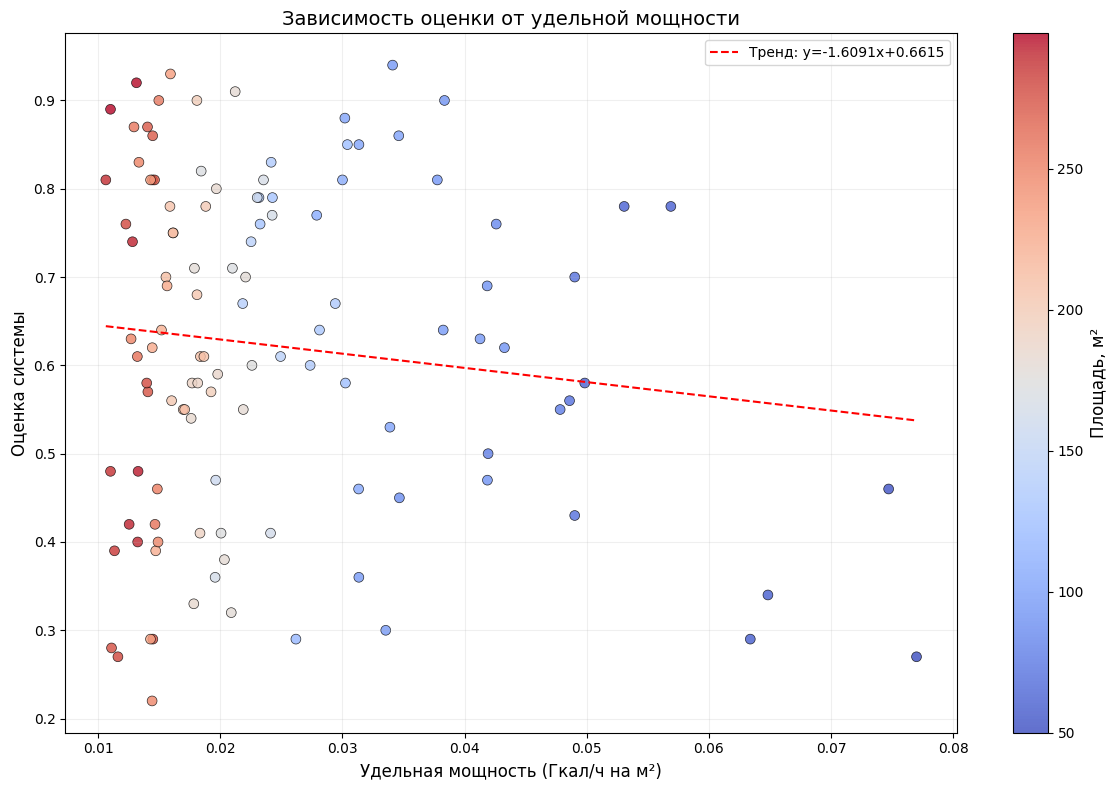

In [10]:
conditions = [
    ('Мощность_Гкал/ч', 'between', (3.0, 4.0)),
    ('Систем_отопления_шт', '>=', 3),
]
filtered_complex = complex_filter(df, conditions)

plot_specific_power_rating(filtered_complex)

In [9]:
filtered_complex.sort_values('Оценка', ascending=False)

,Объект,Тип,Высотное,Помещение,Мощность_Гкал/ч,Площадь_м2,Высота_м,Квадратность,Систем_отопления_шт,Систем_вентиляции_шт,Систем_ГВС_шт,Наличие_колонн,Оценка,Удельная_мощность
602,Manager_91,ЖК,0,ИТП,9.24,84,3.3,0.93,4,2,2,0,0.99,0.110000
609,Pay_33,ЖК,0,ИТП,9.47,85,3.5,0.83,4,2,1,0,0.97,0.111412
137,Us_30,БЦ,0,ИТП,6.62,145,3.6,0.93,3,2,2,0,0.96,0.045655
390,After_92,БЦ,0,ИТП,6.22,126,3.3,1.00,4,1,1,0,0.96,0.049365
290,Ball_19,БЦ,0,ИТП,4.08,179,3.7,0.98,4,1,1,0,0.96,0.022793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,Skill_97,БЦ,1,ИТП,3.56,247,3.1,0.35,3,1,1,1,0.22,0.014413
18,Might_67,БЦ,1,ИТП,2.60,150,3.1,0.14,3,1,1,1,0.22,0.017333
926,Should_71,ЖК,1,ИТП,6.77,278,4.3,0.33,3,2,1,1,0.21,0.024353
533,Street_12,ЖК,1,ИТП,4.50,161,4.5,0.31,3,1,1,1,0.21,0.027950
